##**Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
npz_paths = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all"

In [82]:
INCLUDE_SILENCE = False
SILENCE_CLASS = 20
NUM_FRETS = 20
NUM_CLASSES = NUM_FRETS + int(INCLUDE_SILENCE)

##**Dataset**

In [14]:
from types import SimpleNamespace
import numpy as np
import torch
from torch.utils.data import Dataset

class TabCNNDataset(Dataset):
    def __init__(self, npz_paths, window_size=200, hop_size=200):
        self.samples = []

        for path in npz_paths:
            data = np.load(path, allow_pickle=True)
            cqt = data["cqt"]           # [1, 192, T]
            tab = data["tablature"]     # [6, T]
            T = cqt.shape[-1]

            for start in range(0, T - window_size + 1, hop_size):
                end = start + window_size
                self.samples.append({
                    "cqt": cqt[:, :, start:end],        # [1, 192, 200]
                    "tablature": tab[:, start:end]      # [6, 200]
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        cqt = torch.tensor(item["cqt"], dtype=torch.float32)
        tab = torch.tensor(item["tablature"], dtype=torch.long)

        # 🎯 Sessizlik sınıfını işleme
        if INCLUDE_SILENCE:
            tab[tab == -1] = SILENCE_CLASS
        else:
            tab[tab == -1] = -1

        return {"cqt": cqt, "tablature": tab}

In [15]:
import os

npz_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all"

npz_path_list = [
    os.path.join(npz_dir, fname)
    for fname in sorted(os.listdir(npz_dir))
    if fname.endswith(".npz")
]

In [ ]:
import numpy as np
import os

bad_files = []
diffs = []

for path in npz_path_list:
    data = np.load(path, allow_pickle=True)

    cqt = data["cqt"]
    tab = data["tablature"]

    cqt_len = cqt.shape[-1]
    tab_len = tab.shape[-1]

    if cqt_len != tab_len:
        diff = tab_len - cqt_len
        bad_files.append((os.path.basename(path), cqt_len, tab_len, diff))
        diffs.append(diff)

print(f"Uyuşmazlık bulunan dosya sayısı: {len(bad_files)}")
if diffs:
    print(f"Fark (tablature_len - cqt_len): min={min(diffs)}, max={max(diffs)}, mean={np.mean(diffs):.2f}")
else:
    print("Tüm dosyalar senkronize: tablature ve cqt frame sayıları eşit.")

for name, cqt_len, tab_len, diff in bad_files[:10]:
    print(f"{name}: cqt={cqt_len}, tablature={tab_len}, fark={diff}")

Uyuşmazlık bulunan dosya sayısı: 0
Tüm dosyalar senkronize: tablature ve cqt frame sayıları eşit.


##**Model**

In [97]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # class_weights gibi
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = torch.nn.functional.cross_entropy(input, target, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [98]:
def compute_loss(logits, targets, softmax_module, class_weights=None, use_focal=False, gamma=2.0):
    targets = targets.permute(0, 2, 1)  # [B, T, 6]
    B, T, S, C = logits.shape
    logits = logits.view(B, T, S * C)

    return softmax_module.get_loss(
        logits, targets,
        class_weights=class_weights,
        focal=use_focal,
        gamma=gamma,
        include_silence=INCLUDE_SILENCE
    )

In [99]:
import numpy as np
import torch
from collections import Counter

def compute_per_string_class_weights(
    npz_path_list, num_strings=6, num_classes=21,
    silence_class=20, silence_factor=0.25, include_silence=INCLUDE_SILENCE
):
    """
    Her tel (string) için class ağırlıklarını hesaplar.
    Az görülen sınıflara daha fazla ağırlık verir.
    -1 → silence_class olarak kabul edilir.
    """
    string_counters = [Counter() for _ in range(num_strings)]

    for path in npz_path_list:
        data = np.load(path, allow_pickle=True)
        if "tablature" not in data:
            continue

        tab = data["tablature"]  # [6, T]
        tab = np.where(tab == -1, silence_class, tab)  # Sessizliği net sınıfa taşı

        for s in range(num_strings):
            string_counters[s].update(tab[s].tolist())

    weights = []
    for s in range(num_strings):
        total_counts = string_counters[s]
        class_weights = []

        for cls in range(num_classes):
            count = total_counts.get(cls, 1)  # 1 koyarak sıfır bölme hatası önleniyor
            w = 1.0 / np.log1p(count)
            class_weights.append(w)

        w_tensor = torch.tensor(class_weights, dtype=torch.float32)

        # Sessizlik sınıfını düşür/sıfırla
        if silence_class < len(w_tensor):
            if include_silence:
                w_tensor[silence_class] *= silence_factor
            else:
                w_tensor[silence_class] = 0.0

        # Normalize et (her string için toplamı num_classes olacak şekilde)
        w_tensor = w_tensor / w_tensor.sum() * num_classes
        weights.append(w_tensor)

    return weights  # List of 6 weight vectors [num_classes]


In [100]:
import torch.nn as nn
import torch.nn.functional as F

class SoftmaxGroups(nn.Module):
    def __init__(self, num_groups, group_size):
        super().__init__()
        self.num_groups = num_groups  # örn: 6 strings
        self.group_size = group_size  # örn: 21 classes (fret + silence)

    def forward(self, x):
        B, T, D = x.shape
        x = x.view(B, T, self.num_groups, self.group_size)
        x = F.softmax(x, dim=-1)
        return x.view(B, T, D)

    def get_loss(self, preds, targets, class_weights=None, focal=False, gamma=2.0, include_silence=True):
        B, T, SxC = preds.shape
        S = self.num_groups
        C = self.group_size

        preds = preds.view(B, T, S, C)
        total_loss = 0.0

        for s in range(S):
            pred_s = preds[:, :, s, :].contiguous().view(-1, C)
            target_s = targets[:, :, s].contiguous().view(-1)

            if not INCLUDE_SILENCE:
                mask = target_s != -1
                pred_s = pred_s[mask]
                target_s = target_s[mask]

            weight_s = class_weights[s].to(pred_s.device) if class_weights is not None else None

            if focal:
                ce = F.cross_entropy(pred_s, target_s, weight=weight_s, reduction='none', ignore_index=-1)
                pt = torch.exp(-ce)
                loss = ((1 - pt) ** gamma) * ce
                total_loss += loss.mean()
            else:
                loss_fn = nn.CrossEntropyLoss(weight=weight_s, ignore_index=-1)
                total_loss += loss_fn(pred_s, target_s)

        return total_loss / S

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TabCNN(nn.Module):
    def __init__(self, in_channels=1, num_freq=192, num_frets=20, num_strings=6):
        super().__init__()
        self.num_frets = num_frets
        self.include_silence = INCLUDE_SILENCE
        self.num_classes = num_frets + 1 if self.include_silence else num_frets
        self.num_strings = num_strings
        self.total_output_size = self.num_strings * self.num_classes

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Dropout(0.25)
        )

        conv_out_freq = num_freq // 2
        self.embedding_dim = 64 * conv_out_freq

        self.fc = nn.Sequential(
            nn.Linear(self.embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, self.total_output_size)
        )

        self.softmax_groups = SoftmaxGroups(num_groups=self.num_strings, group_size=self.num_classes)

    def forward(self, x, apply_softmax=False):
        B, C, F, T = x.shape
        out = self.conv(x)
        out = out.permute(0, 3, 1, 2)
        out = out.reshape(B, T, -1)
        out = self.fc(out)

        if apply_softmax:
            out = self.softmax_groups(out)

        return out.view(B, T, self.num_strings, self.num_classes)

In [102]:
def accuracy(logits, targets, include_silence=None):
    if include_silence is None:
        include_silence = INCLUDE_SILENCE

    preds = finalize_output(logits, return_shape="logits", mask_silence=not include_silence)
    targets = targets.permute(0, 2, 1)  # [B, T, 6]

    if not include_silence:
        mask = (targets != -1)
        correct = (preds == targets) & mask
        return correct.sum().float() / mask.sum().float()
    else:
        correct = (preds == targets)
        return correct.sum().float() / targets.numel()

In [103]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_tablature_metrics(logits, targets, include_silence=None, verbose=False):
    if include_silence is None:
        include_silence = INCLUDE_SILENCE

    preds = finalize_output(logits, return_shape="logits", mask_silence=not include_silence)
    targets = targets.permute(0, 2, 1)  # [B, T, 6]

    if not include_silence:
        mask = (targets != -1)
        preds_flat = preds[mask].cpu().numpy()
        targets_flat = targets[mask].cpu().numpy()
    else:
        preds_flat = preds.cpu().numpy().flatten()
        targets_flat = targets.cpu().numpy().flatten()

    precision = precision_score(targets_flat, preds_flat, average='macro', zero_division=0)
    recall = recall_score(targets_flat, preds_flat, average='macro', zero_division=0)
    f1 = f1_score(targets_flat, preds_flat, average='macro', zero_division=0)

    if verbose:
        from sklearn.metrics import classification_report
        print("\n🔍 Classification Report:")
        print(classification_report(targets_flat, preds_flat, zero_division=0))

    return precision, recall, f1

In [89]:
def finalize_output(logits, silence_class=None, return_shape="targets", mask_silence=None):
    """
    logits: [B, T, 6, C]
    return_shape:
        "targets" → [B, 6, T]
        "logits" → [B, T, 6]
    mask_silence: True ise sessizlik -1 yapılır, None ise INCLUDE_SILENCE'a göre belirlenir
    """
    if mask_silence is None:
        mask_silence = not INCLUDE_SILENCE

    preds = logits.argmax(dim=-1)  # [B, T, 6]

    if silence_class is None:
        silence_class = logits.shape[-1] - 1

    if mask_silence:
        preds[preds == silence_class] = -1

    if return_shape == "targets":
        preds = preds.permute(0, 2, 1)

    return preds

##**Train**

In [104]:
from pickle import TRUE
def evaluate_model(model, val_loader, device, class_weights=None, verbose=False):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_batches = 0
    all_prec, all_rec, all_f1 = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            cqt = batch["cqt"].to(device)
            tab = batch["tablature"].to(device)  # [B, 6, T]

            logits = model(cqt, apply_softmax=False)  # raw logits [B, T, 6, C]

            # 🎯 targets: [B, 6, T] → [B, T, 6]
            targets = tab.permute(0, 2, 1)

            # 🔄 logits: [B, T, 6, C] → [B, T, 6*C]
            B, T, S, C = logits.shape
            logits_flat = logits.view(B, T, S * C)

            # 🔢 Loss hesapla
            loss = compute_loss(
                logits, tab,
                softmax_module=model.softmax_groups,
                class_weights=class_weights,
                use_focal=True,
                gamma=2.0
            )

            # 📊 Eval metrikleri
            acc = accuracy(logits, tab, include_silence=INCLUDE_SILENCE)
            prec, rec, f1 = compute_tablature_metrics(logits, tab, include_silence=INCLUDE_SILENCE, verbose=verbose)

            total_loss += loss.item()
            total_acc += acc.item()
            all_prec.append(prec)
            all_rec.append(rec)
            all_f1.append(f1)
            total_batches += 1

    avg_loss = total_loss / total_batches
    avg_acc = total_acc / total_batches
    avg_prec = np.mean(all_prec)
    avg_rec = np.mean(all_rec)
    avg_f1 = np.mean(all_f1)

    print(f"🧪 Val Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f} | P: {avg_prec:.4f} | R: {avg_rec:.4f} | F1: {avg_f1:.4f}")
    return avg_loss, avg_acc, avg_prec, avg_rec, avg_f1


In [105]:
class_weights = compute_per_string_class_weights(
    npz_path_list=npz_path_list,
    num_strings=6,
    num_classes=NUM_CLASSES,
    silence_class=20,
    silence_factor=0.25
)

In [106]:
import pandas as pd
from IPython.display import display

def print_per_string_class_weights_numpy(class_weights_tensor, include_silence=INCLUDE_SILENCE, silence_class=SILENCE_CLASS):
    """
    Her string için sınıf ağırlıklarını gösteren tablo (sessizlik opsiyonel)
    """
    num_strings = len(class_weights_tensor)
    num_classes = class_weights_tensor[0].shape[0]

    # 📊 Dataframe için veriyi hazırla
    data = {
        f'String {s+1}': [f"{class_weights_tensor[s][c].item():.4f}" for c in range(num_classes)]
        for s in range(num_strings)
    }

    # 🎯 Index adlarını oluştur (sessizlik varsa belirt)
    index_names = [
        f"{i}{' (silence)' if include_silence and i == silence_class else ''}"
        for i in range(num_classes)
    ]

    df = pd.DataFrame(data)
    df.index = index_names
    df.index.name = "Class ID"

    # 🔕 Sessizlik dahil değilse o sınıfı gösterme
    if not include_silence:
        df = df.drop(index=f"{silence_class} (silence)", errors="ignore")

    print("🎯 Per-String Class Weights Table:")
    display(df)
    return df

In [92]:
df = print_per_string_class_weights_numpy(class_weights, INCLUDE_SILENCE)

🎯 Per-String Class Weights Table:


,String 1,String 2,String 3,String 4,String 5,String 6
Class ID,,,,,,
0,0.1942,0.2068,0.6009,0.5112,0.5190,0.3945
1,0.2006,0.2206,0.7284,0.5147,0.5173,0.4163
2,0.2048,0.1954,0.5656,0.4948,0.5148,0.4196
3,0.1981,0.1916,0.5501,0.4812,0.5052,0.4064
4,0.1975,0.1870,0.5690,0.4888,0.4989,0.3988
5,0.2142,0.2019,0.5710,0.4859,0.5069,0.4024
6,0.2014,0.1881,0.5428,0.4614,0.4827,0.3916
7,0.2292,0.2065,0.5781,0.4787,0.5100,0.4254
8,0.2387,0.2014,0.5547,0.4841,0.4944,0.4025


In [107]:
import numpy as np
import os
import torch
import pandas as pd
from collections import Counter

def compute_per_string_class_distribution(npz_paths, num_strings=6, include_silence=True):
    """
    Her tel (string) için sınıf dağılımı istatistiği çıkarır.
    Sessizlik class'ı -1 olarak etiketlenmişse:
        - include_silence=True → class N olarak dahil edilir
        - include_silence=False → sessiz frame'ler tamamen atılır

    Returns: DataFrame [num_classes x num_strings] içinde "count (ratio)" hücreleri
    """
    counts = [Counter() for _ in range(num_strings)]
    silence_class = None
    num_classes = None

    for path in npz_paths:
        data = np.load(path, allow_pickle=True)
        if "tablature" not in data:
            continue

        tab = data["tablature"]  # [6, T]

        for s in range(num_strings):
            frets = tab[s]

            if include_silence:
                # Sessizlik class'ını en son sınıfa taşı
                if silence_class is None:
                    silence_class = frets.max() + 1  # otomatik belirle (ör: 20)
                frets = np.where(frets == -1, silence_class, frets)
            else:
                # Sessiz frame'leri at
                frets = frets[frets != -1]

            counts[s].update(frets.tolist())

    # Sınıf sayısını hesapla
    if include_silence:
        num_classes = silence_class + 1
    else:
        num_classes = max(max(counter.keys()) for counter in counts) + 1

    # 📊 DataFrame oluştur
    df_data = {}
    for s in range(num_strings):
        total = sum(counts[s].values())
        row = []
        for c in range(num_classes):
            count = counts[s][c]
            ratio = count / total if total > 0 else 0.0
            row.append(f"{count} ({ratio:.4f})")
        df_data[f"String {s+1}"] = row

    df = pd.DataFrame(df_data)
    df.index = [f"Class {i}" + (" (silence)" if include_silence and i == silence_class else "") for i in range(num_classes)]

    print("🎯 Class Distribution per String (Count + Ratio):")
    return df

In [108]:
from glob import glob
df = compute_per_string_class_distribution(npz_path_list, include_silence=INCLUDE_SILENCE)
from IPython.display import display
display(df)

🎯 Class Distribution per String (Count + Ratio):


,String 1,String 2,String 3,String 4,String 5,String 6
Class 0,14633 (0.1745),9173 (0.0672),10788 (0.0578),11509 (0.0578),11671 (0.0684),9942 (0.1161)
Class 1,10799 (0.1288),5185 (0.0380),2122 (0.0114),10804 (0.0542),12022 (0.0704),6141 (0.0717)
Class 2,8937 (0.1066),15651 (0.1146),19238 (0.1030),15689 (0.0788),12583 (0.0737),5738 (0.0670)
Class 3,12138 (0.1447),18968 (0.1389),25406 (0.1360),20618 (0.1035),15071 (0.0883),7592 (0.0886)
Class 4,12493 (0.1490),24053 (0.1761),18142 (0.0971),17691 (0.0888),17007 (0.0996),9004 (0.1051)
Class 5,5996 (0.0715),11470 (0.0840),17533 (0.0939),18739 (0.0941),14573 (0.0854),8299 (0.0969)
Class 6,10385 (0.1238),22722 (0.1664),29131 (0.1559),31625 (0.1587),23594 (0.1382),10641 (0.1242)
Class 7,3384 (0.0403),9289 (0.0680),15560 (0.0833),21732 (0.1091),13770 (0.0807),5093 (0.0595)
Class 8,2450 (0.0292),11714 (0.0858),23350 (0.1250),19435 (0.0976),18591 (0.1089),8291 (0.0968)
Class 9,1449 (0.0173),3852 (0.0282),9212 (0.0493),11752 (0.0590),10985 (0.0644),4548 (0.0531)


In [109]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, history,
                class_weights=None, epochs=30):
    model.to(device)
    iteration = 0

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        all_prec, all_rec, all_f1 = [], [], []

        for batch in train_loader:
            cqt = batch["cqt"].to(device)
            tab = batch["tablature"].to(device)

            optimizer.zero_grad()
            logits = model(cqt, apply_softmax=False)

            loss = compute_loss(
                logits, tab,
                softmax_module=model.softmax_groups,
                class_weights=class_weights,
                use_focal=True,
                gamma=2.0
            )

            acc = accuracy(logits, tab, include_silence=INCLUDE_SILENCE)
            precision, recall, f1 = compute_tablature_metrics(logits, tab, include_silence=INCLUDE_SILENCE)

            loss.backward()
            optimizer.step()
            scheduler.step()
            iteration += 1

            total_loss += loss.item()
            total_correct += int(acc.item() * tab.numel())
            total_samples += tab.numel()
            all_prec.append(precision)
            all_rec.append(recall)
            all_f1.append(f1)

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_correct / total_samples
        avg_prec = np.mean(all_prec)
        avg_rec = np.mean(all_rec)
        avg_f1 = np.mean(all_f1)

        history["train_loss"].append(avg_loss)
        history["train_acc"].append(avg_acc)
        history["train_precision"].append(avg_prec)
        history["train_recall"].append(avg_rec)
        history["train_f1"].append(avg_f1)
        history["train_total_correct"].append(total_correct)
        history["train_total_samples"].append(total_samples)

        print(f"🎯 Epoch {epoch+1:02d} | Loss/sample: {avg_loss:.6f} | Acc: {avg_acc:.4f} | "
              f"P: {avg_prec:.4f} | R: {avg_rec:.4f} | F1: {avg_f1:.4f}")

        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate_model(
            model, val_loader, device,
            class_weights=class_weights,
            verbose=(epoch == epochs - 1)
        )
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_precision"].append(val_prec)
        history["val_recall"].append(val_rec)
        history["val_f1"].append(val_f1)

In [110]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim

train_paths, val_paths = train_test_split(npz_path_list, test_size=0.2, random_state=42)

train_dataset = TabCNNDataset(train_paths, window_size=200)
val_dataset = TabCNNDataset(val_paths, window_size=200)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)

# Model: sessizlik dahilse 20 fret + 1 silence
model = TabCNN(in_channels=1, num_freq=192, num_frets=NUM_CLASSES)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
device = "cuda" if torch.cuda.is_available() else "cpu"

full_data_history = {
    "train_loss": [], "train_acc": [],
    "train_precision": [], "train_recall": [], "train_f1": [],
    "train_total_correct": [], "train_total_samples": [],
    "val_loss": [], "val_acc": [], "val_precision": [], "val_recall": [], "val_f1": []
}

train_model(model, train_loader, val_loader, optimizer, scheduler,
            device, full_data_history, class_weights=class_weights, epochs=30)

🎯 Epoch 01 | Loss/sample: 0.486466 | Acc: 0.1875 | P: 0.1372 | R: 0.1178 | F1: 0.1113
🧪 Val Loss: 0.2679 | Acc: 0.5323 | P: 0.4968 | R: 0.4082 | F1: 0.3830
🎯 Epoch 02 | Loss/sample: 0.225212 | Acc: 0.5427 | P: 0.4671 | R: 0.4419 | F1: 0.4353
🧪 Val Loss: 0.1506 | Acc: 0.7300 | P: 0.5999 | R: 0.6019 | F1: 0.5692
🎯 Epoch 03 | Loss/sample: 0.155918 | Acc: 0.6631 | P: 0.5701 | R: 0.5662 | F1: 0.5522
🧪 Val Loss: 0.1162 | Acc: 0.7690 | P: 0.6459 | R: 0.6358 | F1: 0.6071
🎯 Epoch 04 | Loss/sample: 0.130406 | Acc: 0.7071 | P: 0.6003 | R: 0.5988 | F1: 0.5833
🧪 Val Loss: 0.0980 | Acc: 0.7976 | P: 0.6755 | R: 0.6651 | F1: 0.6389
🎯 Epoch 05 | Loss/sample: 0.112980 | Acc: 0.7374 | P: 0.6256 | R: 0.6193 | F1: 0.6059
🧪 Val Loss: 0.0889 | Acc: 0.8063 | P: 0.6755 | R: 0.6701 | F1: 0.6465
🎯 Epoch 06 | Loss/sample: 0.101268 | Acc: 0.7551 | P: 0.6298 | R: 0.6343 | F1: 0.6179
🧪 Val Loss: 0.0831 | Acc: 0.8173 | P: 0.7062 | R: 0.6870 | F1: 0.6695
🎯 Epoch 07 | Loss/sample: 0.092802 | Acc: 0.7699 | P: 0.6460 | R

## **Train Eval**

In [111]:
def accuracy_per_string(logits, targets, silence_class=20):
    preds = logits.argmax(dim=-1)  # [B, T, 6]
    targets = targets.permute(0, 2, 1)  # [B, T, 6]

    results = []
    for s in range(6):  # her tel için
        pred_s = preds[..., s]
        target_s = targets[..., s]

        mask = (target_s != -1)
        correct = (pred_s == target_s) & mask

        acc = correct.sum().item() / mask.sum().item()
        results.append(acc)

    return results

In [112]:
from sklearn.metrics import classification_report
import numpy as np

def stringwise_classification_report(logits, targets, silence_class=20):
    preds = logits.argmax(dim=-1)         # [B, T, 6]
    targets = targets.permute(0, 2, 1)    # [B, T, 6]

    for s in range(6):
        p = preds[..., s].flatten().cpu().numpy()
        t = targets[..., s].flatten().cpu().numpy()
        m = t != -1
        p = p[m]
        t = t[m]
        unique_classes = np.unique(np.concatenate([t, p]))

        print(f"\n🎸 String {s+1} Classification Report:")
        print(classification_report(
            t, p,
            labels=unique_classes,
            zero_division=0,
            digits=2
        ))

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def confusion_matrix_per_string(logits, targets, silence_class=20, num_classes=21):
    """
    logits: [B, T, 6, C]
    targets: [B, 6, T]
    """
    preds = logits.argmax(dim=-1)         # [B, T, 6]
    targets = targets.permute(0, 2, 1)    # [B, T, 6]

    for s in range(6):
        p = preds[..., s].flatten().cpu().numpy()
        t = targets[..., s].flatten().cpu().numpy()
        mask = t != -1

        p = p[mask]
        t = t[mask]

        cm = confusion_matrix(t, p, labels=list(range(num_classes)))

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
        plt.title(f"🎸 Confusion Matrix - String {s+1}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

In [114]:
batch = next(iter(val_loader))
cqt = batch["cqt"].to(device)
tab = batch["tablature"].to(device)

logits = model(cqt, apply_softmax=False)

In [115]:
accuracy_per_string(logits, tab)

[0.9680672268907563,
 0.8813972380178716,
 0.8602865916069601,
 0.8145258103241296,
 0.8383900928792569,
 0.9088858818222824]

In [116]:
stringwise_classification_report(logits, tab)


🎸 String 1 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.12      0.19        17
           1       1.00      1.00      1.00        89
           3       0.94      0.99      0.96       252
           4       1.00      0.98      0.99       258
           6       0.99      0.98      0.99       540
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.91      0.91      0.91        34

    accuracy                           0.97      1190
   macro avg       0.59      0.55      0.56      1190
weighted avg       0.97      0.97      0.97      1190


🎸 String 2 Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        14
           1       0.00      0.00      0.00         0
           2       0.99      0.92      0.95        97
        

/tmp/ipython-input-113-4275417358.py:28: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


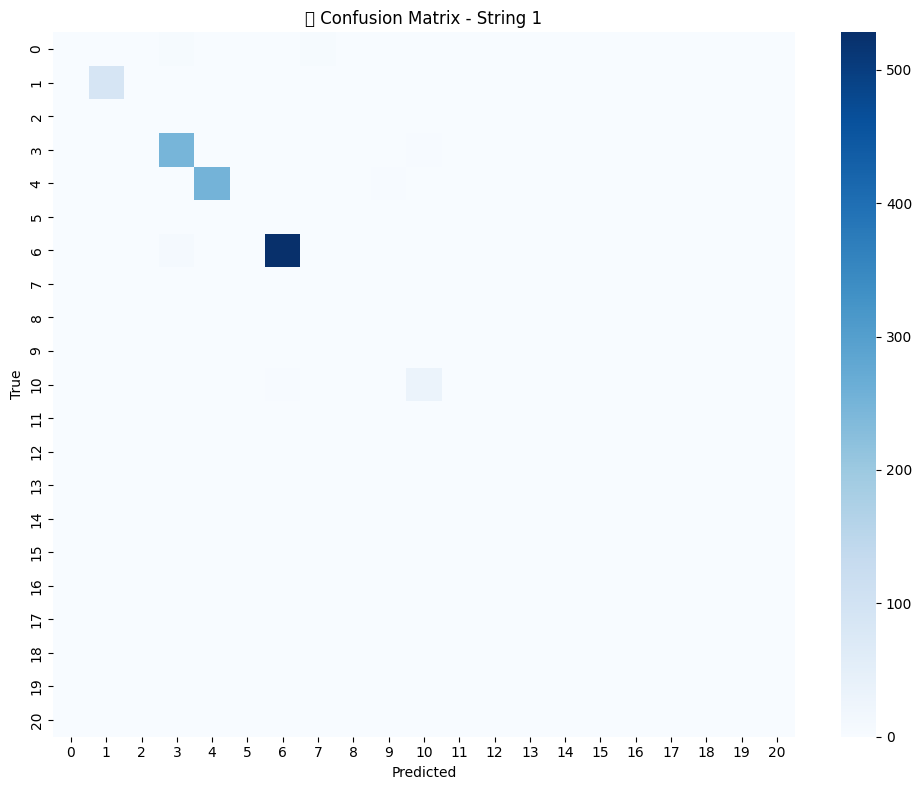

/tmp/ipython-input-113-4275417358.py:28: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


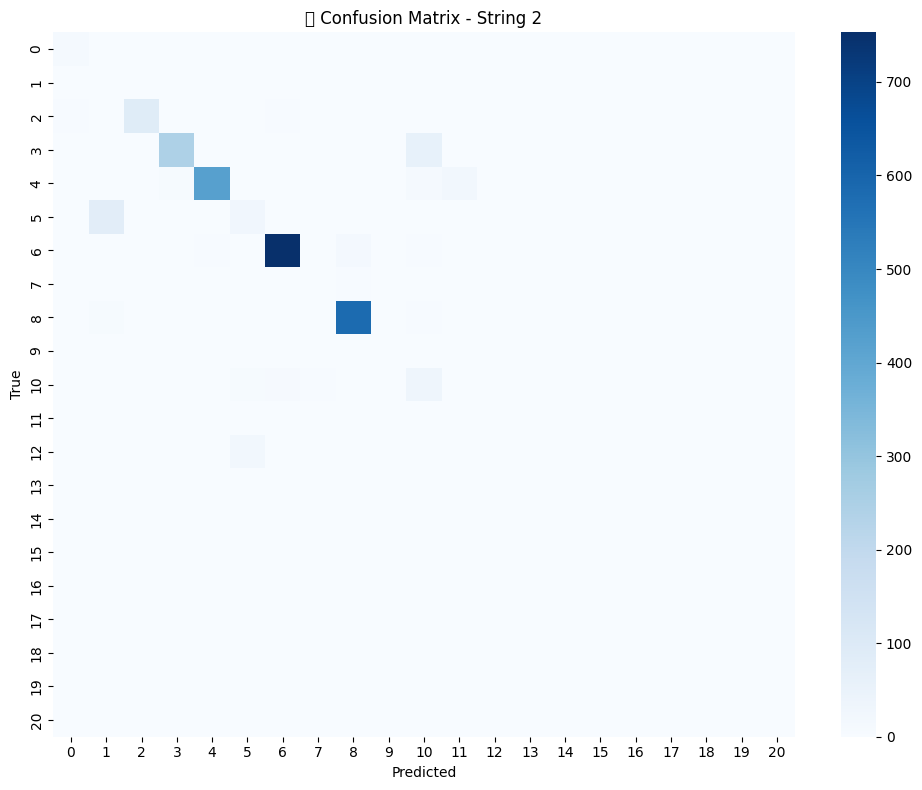

/tmp/ipython-input-113-4275417358.py:28: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


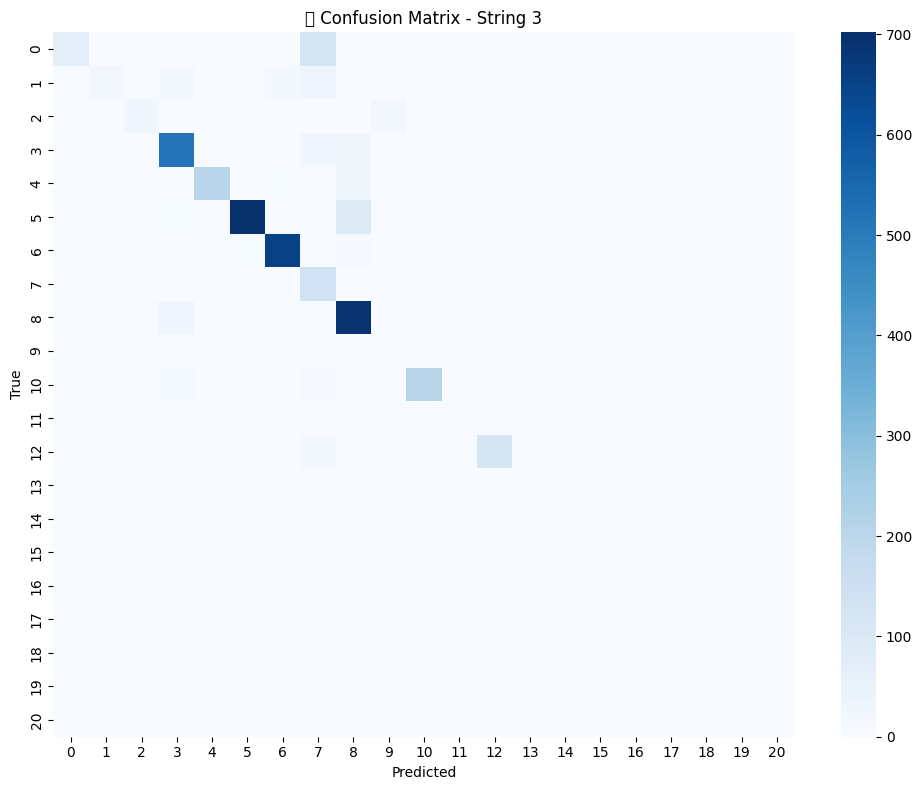

/tmp/ipython-input-113-4275417358.py:28: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


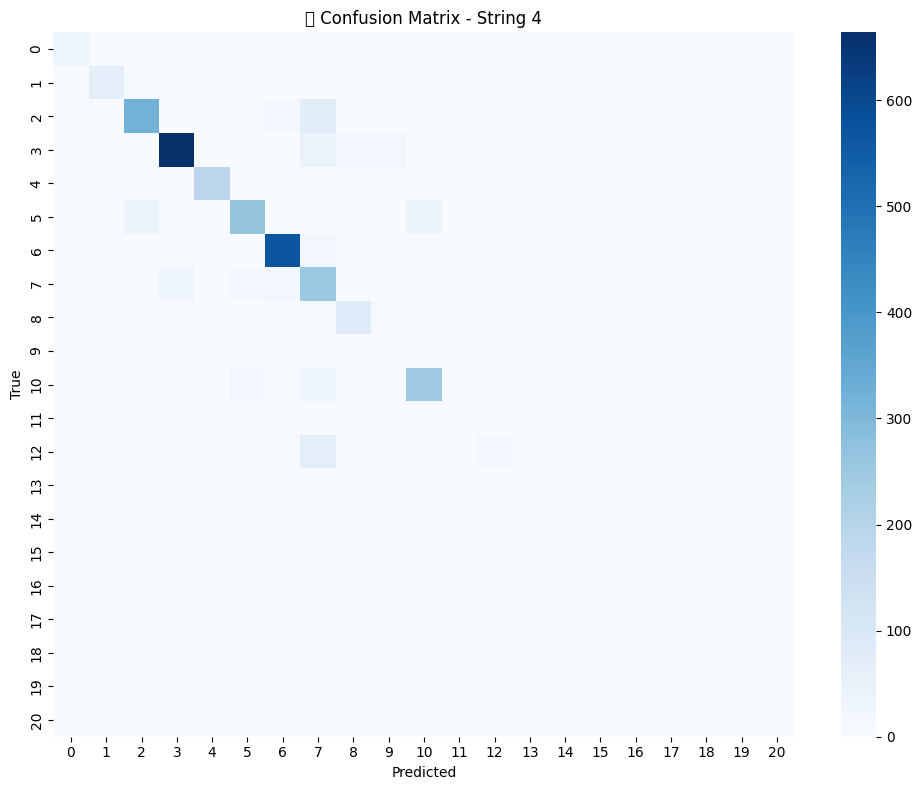

/tmp/ipython-input-113-4275417358.py:28: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


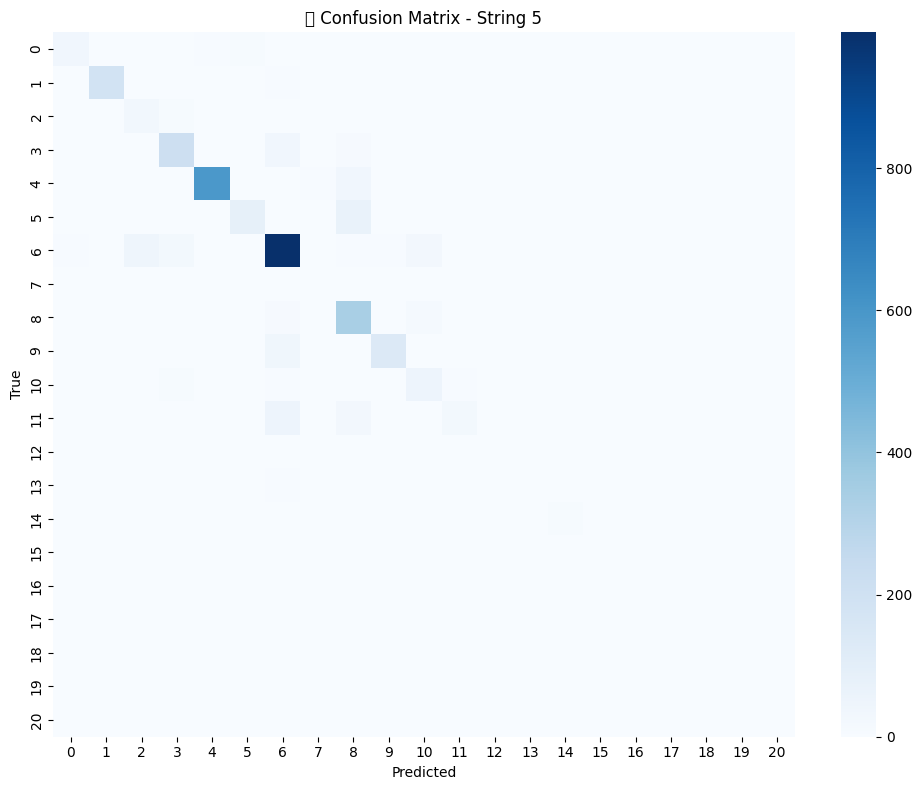

/tmp/ipython-input-113-4275417358.py:28: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


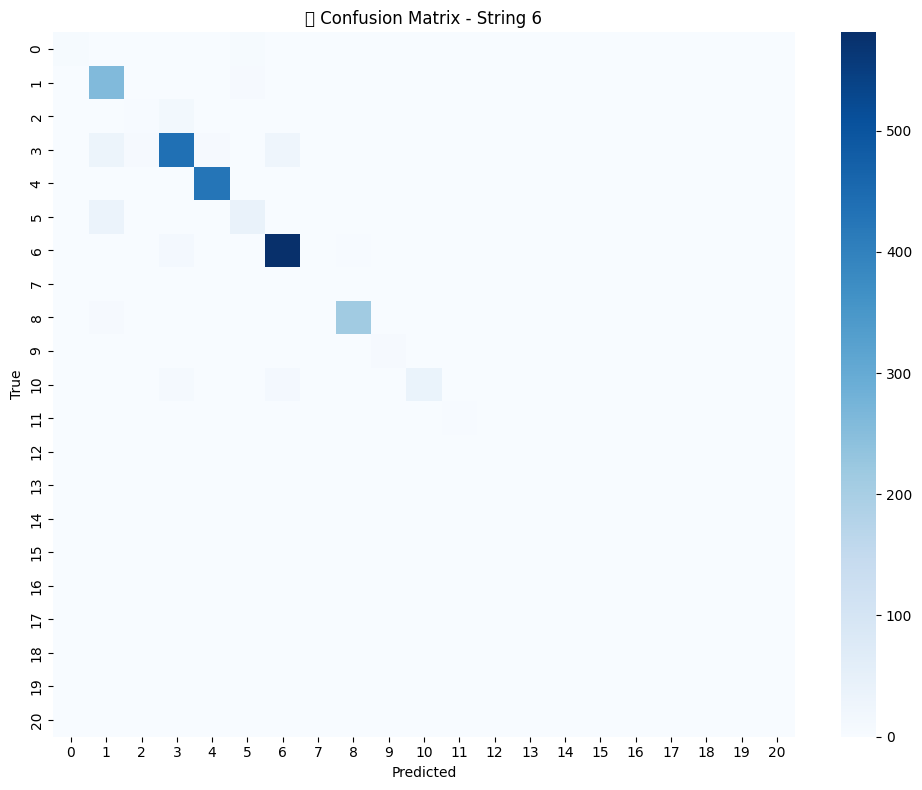

In [117]:
confusion_matrix_per_string(logits, tab)